In [7]:
%load_ext autoreload
%autoreload 2

import itertools
import matplotlib.pyplot as plt
import numpy as np
from prob_eqloc import likelihood,MCMC,simulate_loss,synthetic_seis
import seaborn as sns

plt.rcParams["font.family"] = "Times New Roman"

fs=14
np.random.seed(320)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define a 2D synthetic search domain

In [2]:
# X representing the horizontal distance in km
# Z representing the depth positive downwards in km
Xmin,Xmax,Zmin,Zmax = 0,50,-2,10
centx,centz = ((Xmax-Xmin)/2),((Zmax-Zmin)/2)
bounds = np.stack([[Xmin,Xmax,Xmax,Xmin,Xmin],[Zmin,Zmin,Zmax,Zmax,Zmin]],axis=1)

# ---- Seismic Station Locations ----
n                       = 15   # Number of seismic stations
n_error                 = 2    # Number of stations with erroneous results 
observation_uncertainty = 0.15 # Standard Deviation uncertainty in phase arrivals (all stations equal)

Xc      = np.zeros((n,2))
Xc[:,0] = sorted(np.random.uniform(low=Xmin, high=Xmax, size=(n)))
Xc[:,1] = 0  # Setting stations at surface 

# --- Defining a random source location
Xs =  [np.random.uniform(low=Xmin, high=Xmax),
       np.random.uniform(low=0, high=Zmax)]

# --- Determining the observed travel-times for a single-phase ---
Vh = 4.5 #km/s

# Determining the observational Travel-Times assuming origin time t0=0.0
to = np.sqrt(np.sum(np.square(Xc - Xs),axis=1))/Vh

# Altering the observations to include some stations with large uncertainty
to[:n_error] = to[:n_error] + np.random.uniform(low=-0.5, high=+0.5, size=(to[:n_error].shape))
obs_sigma = np.ones(to.shape)*observation_uncertainty

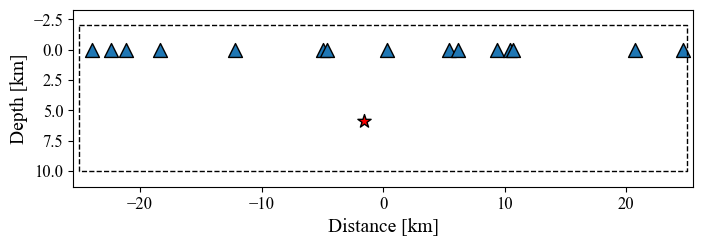

In [3]:
fig,ax = plt.subplots(figsize=(8,2.3))
sz = 100
ax.scatter(Xc[:,0]-centx,Xc[:,1],marker="^",ec="k",s=sz)
ax.plot(bounds[:,0]-centx,bounds[:,1],lw=1,ls="--",c="k")
ax.scatter(Xs[0]-centx,Xs[1],marker="*",ec="k",c="r",s=sz)
ax.invert_yaxis(), ax.margins(x=0.01), ax.axis("equal")
ax.set_xlabel("Distance [km]",fontsize=fs),ax.set_ylabel("Depth [km]",fontsize=fs)
for ticks in (ax.get_xticklabels() + ax.get_yticklabels()):
    ticks.set_fontsize(fs-2)
# plt.savefig("Figures/01_Model_Limits.png", dpi=200, bbox_inches="tight")
plt.show()

### Plot the waveform arrivals at each station

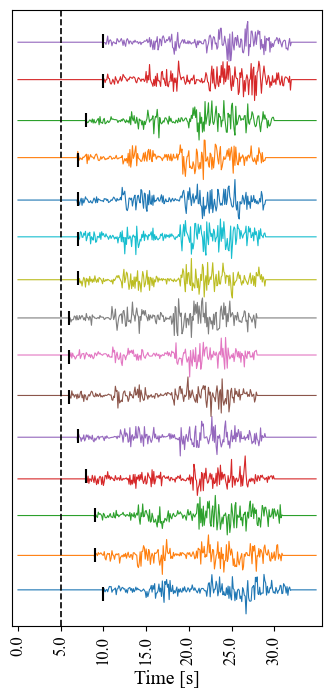

In [4]:
fig,ax = plt.subplots(figsize=(4,8))
xidxs = np.arange(0,350, 1)
freq = 10
origin_time = 5
for i,arv_t in enumerate(to):
    wavf = synthetic_seis(len(xidxs),arv_t+origin_time, freq=freq)
    ax.plot(xidxs,wavf+i,lw=0.8)
    ax.scatter((np.floor(arv_t+origin_time))*freq,i+0.5,marker="|",c="k",s=100,zorder=2)
xidxs_ticks = np.arange(0, len(xidxs), freq*5)
ax.axvline(origin_time*freq,ls="--",lw=1.2,c="k")
ax.margins(x=0.02,y=0.02),
ax.set_xticks(xidxs_ticks),ax.set_xticklabels(xidxs_ticks/freq,rotation=90),ax.set_yticks([])
ax.set_xlabel("Time [s]",fontsize=fs)
for ticks in (ax.get_xticklabels() + ax.get_yticklabels()):
    ticks.set_fontsize(fs-2)
# plt.savefig("Figures/02_Travel_times_syn_waveforms.png", dpi=200, bbox_inches="tight")
plt.show()


### Earthquake Location Inversion

In [6]:
Tpred_UncertaintyParams = [0.05,0.01,0.5] 

pairs     = np.array(list(itertools.combinations(np.arange(len(to)), 2)))
ix = pairs[:,0]
iy = pairs[:,1]


# Define the simulation configuration file
Params = {}
Params['X_Bounds']     = [Xmin,Xmax] # X dimension search region bounds
Params['Z_Bounds']     = [Zmin,Zmax] # Z dimension search region bounds
Params['X_station']    = Xc
Params['Tobs']         = to                #Observational Station Arrival Times
Params['Tobs_sigma']   = obs_sigma         #Observational Station Arrival Times Uncertainty
Params['Tpred_Params'] = Tpred_UncertaintyParams

In [8]:
nsim = 10000
results = simulate_loss(Params, Xmin, Xmax, Zmin, Zmax, Xc, Vh, ix, iy, nsim=nsim)

sim_loss = results["sim_loss"]
sim_Xeqloc = results["sim_Xeqloc"]
sim_Zeqloc = results["sim_Zeqloc"]
single_rlz_loss = results["last_rlz_loss"]
single_rlz_xloc = results["last_rlz_Xeqloc"]
single_rlz_zloc = results["last_rlz_Zeqloc"]

100%|██████████| 10000/10000 [15:27<00:00, 10.79it/s]


### Create the plots 

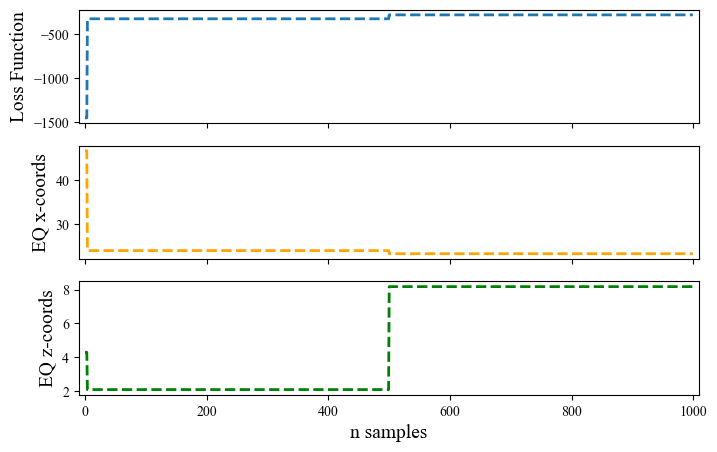

In [31]:
fig,ax = plt.subplots(3,1,figsize=(8,5),sharex=True)
ax[0].plot(single_rlz_loss,lw=2,ls="--"),ax[0].margins(x=0.01)
ax[1].plot(single_rlz_xloc,lw=2,ls="--",c="orange")
ax[2].plot(single_rlz_zloc,lw=2,ls="--",c="g")
ax[2].set_xlabel("n samples", fontsize=fs)
ax[0].set_ylabel("Loss Function", fontsize=fs)
ax[1].set_ylabel("EQ x-coords", fontsize=fs)
ax[2].set_ylabel("EQ z-coords", fontsize=fs)
plt.savefig("Figures/03_Metr_Hast_Chain_EDT.png", dpi=200, bbox_inches="tight")
plt.show()

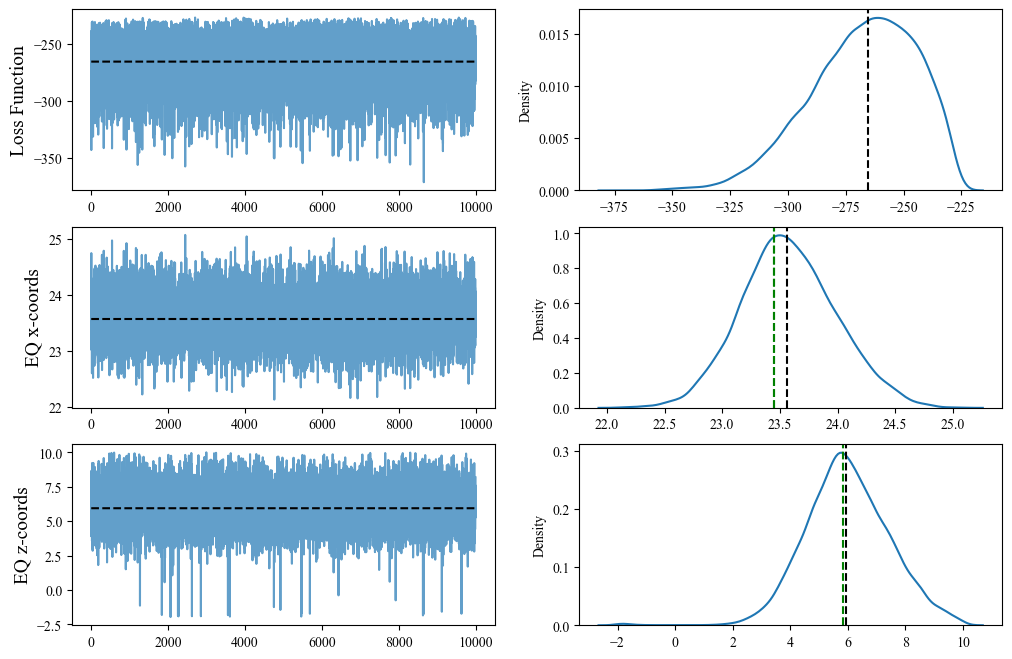

In [46]:
fig,ax = plt.subplots(3,2, figsize=(12,8))
xsim_axis = np.arange(0,nsim)
mdn_loss = np.percentile(sim_loss,50)
mdn_xloc = np.percentile(sim_Xeqloc,50)
mdn_zloc = np.percentile(sim_Zeqloc,50)
ax[0,0].plot(sim_loss,alpha=0.7),ax[0,0].plot(np.ones_like(xsim_axis)*mdn_loss,ls="--",c="k")
ax[1,0].plot(sim_Xeqloc,alpha=0.7),ax[1,0].plot(np.ones_like(xsim_axis)*mdn_xloc,ls="--",c="k")
ax[2,0].plot(sim_Zeqloc,alpha=0.7),ax[2,0].plot(np.ones_like(xsim_axis)*mdn_zloc,ls="--",c="k")
sns.kdeplot(sim_loss, ax=ax[0,1]),ax[0,1].axvline(mdn_loss,ls="--",c="k"),ax[1,1].axvline(Xs[0],ls="--",c="g")
sns.kdeplot(sim_Xeqloc, ax=ax[1,1]),ax[1,1].axvline(mdn_xloc,ls="--",c="k"),ax[1,1].axvline(Xs[0],ls="--",c="g")
sns.kdeplot(sim_Zeqloc, ax=ax[2,1]),ax[2,1].axvline(mdn_zloc,ls="--",c="k"),ax[2,1].axvline(Xs[1],ls="--",c="g")
ax[0,0].set_ylabel("Loss Function", fontsize=fs)
ax[1,0].set_ylabel("EQ x-coords", fontsize=fs)
ax[2,0].set_ylabel("EQ z-coords", fontsize=fs)

plt.savefig("Figures/04_Manual_MCMC_implementation.png", dpi=200, bbox_inches="tight")
plt.show()


### Pymc3 implementation

-----------------------------------------------------
----------- MCMC Parameter Estimation ---------------


/Users/josesmac/Desktop/UA_Files_Joses/UA_PhD_Coursework_Assignments/uaenv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [Earthquake Z Location, Earthquake X Location]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_400 tune and 10_000 draw iterations (5_600 + 40_000 draws total) took 37 seconds.


-----------------------------------------------------
--------  Drawing Samples from Distribution -------- 


/Users/josesmac/Desktop/UA_Files_Joses/UA_PhD_Coursework_Assignments/uaenv/lib/python3.9/site-packages/pymc3/sampling.py:1717: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


-----------------------------------------------------
-------------  Plotting and Summary  --------------- 
                         mean     sd  hdi_3%  hdi_97%
Earthquake X Location  23.465  0.030  23.415   23.527
Earthquake Z Location   5.819  0.085   5.643    5.975


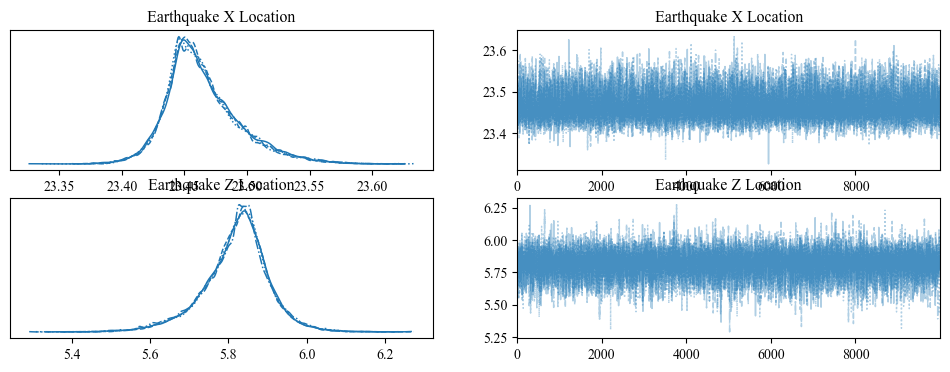

In [16]:
trace,summary,drawn_samples = MCMC(likelihood,Params,Vh,ix,iy)
print(summary)


### Plot the overlay of the ground truth and predicted EQ locations

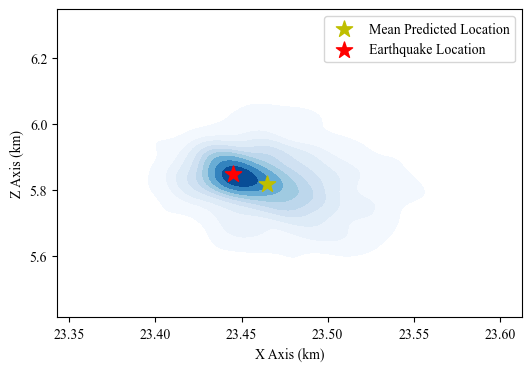

In [47]:
# Calculate the predicted travel times and locations
pred_loc = [summary['mean']['Earthquake X Location'],summary['mean']['Earthquake Z Location']]
tp = np.sqrt(np.sum(np.square(Xc - pred_loc),axis=1))/Vh

# Plotting the predicted location and colourmap of uncertainty
fig, ax = plt.subplots(figsize=(6,4))
quad1 = sns.kdeplot(x=drawn_samples['Earthquake X Location'][:1000],
                    y=drawn_samples['Earthquake Z Location'][:1000],ax=ax,cmap='Blues',fill=True)
ax.scatter(pred_loc[0],pred_loc[1],s=150,c='y',marker='*',label='Mean Predicted Location')
ax.scatter(Xs[0],Xs[1],s=150,c='r',marker='*',label='Earthquake Location')

ax.set_xlabel('X Axis (km)')
ax.set_ylabel('Z Axis (km)')
plt.legend()
plt.savefig("Figures/06_Predicted_location_overlays.png", dpi=200, bbox_inches="tight")
plt.show()

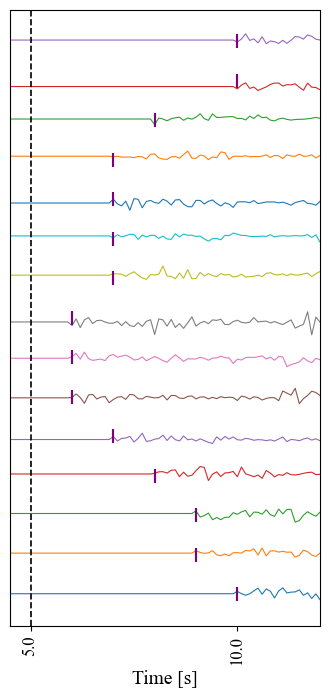

In [49]:
fig,ax = plt.subplots(figsize=(4,8))
xidxs = np.arange(0,350, 1)
freq = 10
origin_time = 5
for i,arv_t in enumerate(to):
    wavf = synthetic_seis(len(xidxs),arv_t+origin_time, freq=freq)
    ax.plot(xidxs,wavf+i,lw=0.8)
    ax.scatter((np.floor(arv_t+origin_time))*freq,i+0.5,marker="|",c="b",s=100,zorder=2)
    ax.scatter((np.floor(tp[i]+origin_time))*freq,i+0.5,marker="|",c="r",s=100,zorder=2,alpha=0.5)
xidxs_ticks = np.arange(0, len(xidxs), freq*5)
ax.axvline(origin_time*freq,ls="--",lw=1.2,c="k")
ax.margins(x=0.02,y=0.02),
ax.set_xticks(xidxs_ticks),ax.set_xticklabels(xidxs_ticks/freq,rotation=90),ax.set_yticks([])
ax.set_xlabel("Time [s]",fontsize=fs), ax.set_xlim(45,120)
for ticks in (ax.get_xticklabels() + ax.get_yticklabels()):
    ticks.set_fontsize(fs-2)
plt.savefig("Figures/07_Predicted_Travel_times_syn_waveforms.png", dpi=200, bbox_inches="tight")
plt.show()